<a href="https://colab.research.google.com/github/andrespollano/neural_nets-tda/blob/main/MNIST/Fashion_CNN_TDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install keras
!pip install giotto-tda

# Load data

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

# Load MNIST dataset
(x_mnist, y_mnist), (x_mnist_test, y_mnist_test) = mnist.load_data()

# Load Fashion-MNIST dataset
(x_fashion, y_fashion), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

# Train CNN Model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np

In [4]:
# Preprocess the data
x_train = x_mnist.reshape(x_mnist.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_mnist, 10)
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], 28, 28, 1).astype('float32') / 255
y_mnist_test = to_categorical(y_mnist_test, 10)

# Define the model
inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
last_hidden_layer_output = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(last_hidden_layer_output)

model = Model(inputs=inputs, outputs=predictions)

# Define a model that outputs the last hidden layer
hidden_model = Model(inputs=model.input, outputs=last_hidden_layer_output)

In [5]:
model_weights_file = 'model_weights.h5'
hidden_model_weights_file = 'hidden_model_weights.h5'

try:
  # load weights if file exist
  model.load_weights(model_weights_file)
  hidden_model.load_weights(hidden_model_weights_file)

except FileNotFoundError:
  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_mnist_test, y_mnist_test))

  # Save model weights
  model.save_weights(model_weights_file)

  # Save weights for the hidden_model
  hidden_model.save_weights(hidden_model_weights_file)


# Generate hiddel layer outputs

In [6]:
# Preprocess the fashion data
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 28, 28, 1).astype('float32') / 255
y_fashion_test = to_categorical(y_fashion_test, 10)

# Get last hidden layer representation for MNIST and Fashion-MNIST
hidden_outputs_mnist = hidden_model.predict(x_mnist_test)
hidden_outputs_fashion = hidden_model.predict(x_fashion_test)

hidden_outputs_mnist.shape, hidden_outputs_fashion.shape

313/313 [==============================] - 4s 14ms/step


((10000, 128), (10000, 128))

# Plot results

## MNIST Hidden Layer outputs

In [7]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

pca = PCA(n_components=3)
mnist_hidden_pca = pca.fit_transform(hidden_outputs_mnist)

plot_point_cloud(mnist_hidden_pca)

## Fashion Hidden Layer outputs

In [8]:
fashion_hidden_pca = pca.transform(hidden_outputs_fashion)
plot_point_cloud(fashion_hidden_pca)

## EMNIST Hidden Layer Outputs

In [ ]:
import tensorflow_datasets as tfds

# Load the EMNIST dataset
emnist_data = tfds.load('emnist/letters')

# The 'train' and 'test' splits are available
emnist_train, emnist_test = emnist_data['train'], emnist_data['test']

In [10]:
# Convert dataset to numpy arrays
def dataset_to_array(dataset):
    """
    Converts a tf.data.Dataset of images to a numpy array.
    """
    images = []

    # Iterate over the dataset
    for example in tfds.as_dataframe(dataset).to_dict('records'):
        # Extract the image and append it to the list
        images.append(example['image'])

    # Stack all images into a single numpy array and return it
    return np.stack(images)

# Convert the train and test datasets to numpy arrays
emnist_train_array = dataset_to_array(emnist_train)
emnist_test_array = dataset_to_array(emnist_test)

In [11]:
emnist_test_array.shape

(14800, 28, 28, 1)

In [12]:
from gtda.plotting import plot_heatmap

# Extract labels from dataset
def extract_labels(dataset):
    """
    Extracts labels from a tf.data.Dataset object and returns them as a numpy array.
    """
    labels = []
    for example in dataset:
        labels.append(example['label'])

    # Convert the list of labels to a numpy array and return it
    return np.array(labels)

# Extract labels for the training and test datasets
y_emnist = extract_labels(emnist_train)
y_emnist_test = extract_labels(emnist_test)

In [13]:
# Visualise example
emnist_test_array_sq = np.squeeze(emnist_test_array)
emnist_test_array_sq
idx = np.flatnonzero(y_emnist_test == 9)[4]
img = emnist_test_array_sq[idx] # Shape (28,28)
plot_heatmap(img)

In [14]:
# Extract hidden layer outputs
hidden_outputs_emnist = hidden_model.predict(emnist_test_array)
np.random.seed(42)
np.random.shuffle(hidden_outputs_emnist)
hidden_outputs_emnist = hidden_outputs_emnist[:10000]
hidden_outputs_emnist.shape

463/463 [==============================] - 5s 11ms/step


(10000, 128)

In [15]:
# Perform PCA (n=3) and visualise hidden layer outputs
emnist_hidden_pca = pca.transform(hidden_outputs_emnist)
plot_point_cloud(emnist_hidden_pca)

# Topological feature extraction

In [16]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude, PersistenceEntropy
from sklearn.pipeline import make_pipeline, make_union

homology_dimensions = [0,1,2,3]
# Select a variety of metrics to calculate amplitudes
amplitude_metrics = ["bottleneck", "wasserstein"]


def generate_topological_features(hidden_layer_data):
  # Generate diagrams
  persistence = VietorisRipsPersistence(
      metric="euclidean",
      homology_dimensions=homology_dimensions,
      collapse_edges=True,
  )

  diagrams = persistence.fit_transform(hidden_layer_data)

  metrics = [
    {"metric": metric}
    for metric in amplitude_metrics
  ]

  # Generate features
  feature_union = make_union(
      *[PersistenceEntropy(nan_fill_value=-1)]
      + [Amplitude(**metric, n_jobs=-1) for metric in metrics]
  )

  tda_features = feature_union.fit_transform(diagrams)

  # print(f' {tda_features.shape[1]} features created for {tda_features.shape[0]} point cloud')

  return tda_features


def generate_feature_names():
  # Names of the persistence entropy features
  persistence_entropy_feature_names = [f'persistence_entropy_dim_{dim}' for dim in homology_dimensions]

  # Names of the amplitude features
  amplitude_feature_names = [f'amplitude_{metric}_dim_{dim}' for metric in amplitude_metrics for dim in homology_dimensions]

  # Combining all feature names
  feature_names = persistence_entropy_feature_names + amplitude_feature_names

  return feature_names

In [17]:
import pandas as pd

def split_data(data, N):
    # Randomly shuffle the data along the first axis (i.e., shuffle the instances)
    np.random.seed(42)
    np.random.shuffle(data)
    # Split the data into N chunks
    chunks = np.array_split(data, N)

    return chunks

datasets = {'mnist' : hidden_outputs_mnist, 'fmnist': hidden_outputs_fashion, 'emnist': hidden_outputs_emnist}

n_chunks = 10
columns = generate_feature_names()
point_could_features = pd.DataFrame(columns=columns)

for name, dataset in datasets.items():
  splits = split_data(dataset, n_chunks)
  for split_idx, split in enumerate(splits):
    batch_name = f'{name}_{split_idx}'
    split = split.reshape(1, *split.shape)
    tda_features = generate_topological_features(split) #array (1,9)
    point_could_features.loc[batch_name] = tda_features[0]

  print(f'{n_chunks} point clouds created for {name}')

10 point clouds created for mnist
10 point clouds created for fmnist
10 point clouds created for emnist


In [18]:
point_could_features

,persistence_entropy_dim_0,persistence_entropy_dim_1,persistence_entropy_dim_2,persistence_entropy_dim_3,amplitude_bottleneck_dim_0,amplitude_bottleneck_dim_1,amplitude_bottleneck_dim_2,amplitude_bottleneck_dim_3,amplitude_wasserstein_dim_0,amplitude_wasserstein_dim_1,amplitude_wasserstein_dim_2,amplitude_wasserstein_dim_3
mnist_0,9.895593,8.701325,6.974355,4.759135,6.257818,1.507676,0.450786,0.192667,103.140357,8.251247,2.028790,0.521473
mnist_1,9.898285,8.641618,6.979918,3.984979,6.064442,1.372067,0.399179,0.239094,103.183134,7.930393,1.674970,0.436496
mnist_2,9.892815,8.749156,6.970347,4.318220,6.675515,1.242965,0.408767,0.240230,103.669209,7.882723,1.846839,0.572973
mnist_3,9.900113,8.776240,7.196986,4.852600,6.047410,1.565789,0.523242,0.196772,103.650346,8.257219,2.170512,0.512554
mnist_4,9.894666,8.709905,6.827997,3.651488,6.529446,1.657162,0.471596,0.151078,103.310827,8.226684,1.659753,0.298940
mnist_5,9.894853,8.701074,6.677194,4.227658,6.318693,1.354372,0.491303,0.148964,102.039723,8.130694,1.664204,0.288200
mnist_6,9.900994,8.714819,7.262110,4.561885,6.490630,1.349909,0.560923,0.196072,103.437413,7.679131,2.196005,0.430708
mnist_7,9.887568,8.621780,6.870136,4.427657,5.950240,1.483824,0.411128,0.276289,100.468189,8.077767,1.561556,0.635442
mnist_8,9.900105,8.781800,7.239884,4.622346,6.517838,1.425765,0.380695,0.305001,101.220205,7.880295,1.822847,0.560412
mnist_9,9.896654,8.785009,6.997195,4.283488,6.004251,1.205048,0.499945,0.448818,101.228544,7.831854,1.944511,0.665051


In [19]:
import pandas as pd

tda_features_file = 'tda_features.pkl'
try:
  point_could_features = pd.read_pickle(tda_features_file)
except FileNotFoundError:
  point_could_features.to_pickle(tda_features_file)

In [20]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from sklearn import preprocessing

# normalize data
data_scaled = pd.DataFrame(preprocessing.scale(point_could_features),columns = point_could_features.columns)

pca = PCA(n_components=3)
tda_pca3 = pca.fit_transform(data_scaled)

# Dump components relations with features:
pd.DataFrame(pca.components_,columns=data_scaled.columns,index = pca.get_feature_names_out())

plot_point_cloud(tda_pca3)

/usr/local/lib/python3.10/dist-packages/yellowbrick/features/pca.py:458: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



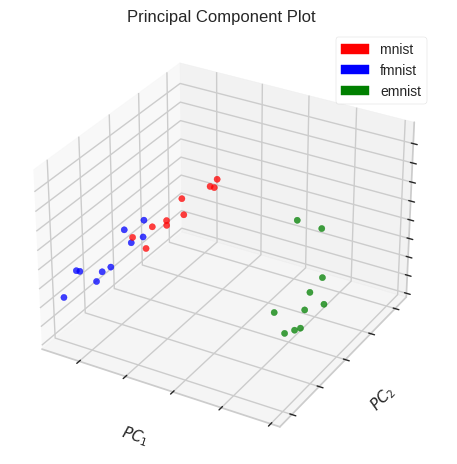

<Axes3D: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$', zlabel='$PC_3$'>

In [21]:
from yellowbrick.features import PCA
le = preprocessing.LabelEncoder()

labels = [0]*10 + [1]*10 + [2]*10
plot_3d = PCA(scale=True, projection=3, classes=['mnist', 'fmnist', 'emnist'], random_state=42, colors=['red', 'blue', 'green'])
plot_3d.fit_transform(point_could_features, labels)
plot_3d.show()

In [55]:
import numpy as np
from scipy.stats import energy_distance

def energy_two_sample_test(X, Y, num_permutations=1000):
    # Compute the original energy distance
    original_energy_dist = energy_distance(X.flatten(), Y.flatten())

    # Perform the permutation test
    permuted_energy_values = []
    combined_sample = np.vstack([X, Y])
    for _ in range(num_permutations):
        np.random.shuffle(combined_sample)
        permuted_X = combined_sample[:len(X)]
        permuted_Y = combined_sample[len(X):]
        permuted_energy = energy_distance(permuted_X.flatten(), permuted_Y.flatten())
        permuted_energy_values.append(permuted_energy)

    # Compute the p-value
    p_value = np.mean(np.array(permuted_energy_values) >= original_energy_dist)
    return original_energy_dist, p_value

# Example usage
X = data_scaled.iloc[:5].to_numpy()
Y = data_scaled.iloc[5:10].to_numpy()

energy_dist, p_value = energy_two_sample_test(X, Y)
print("Energy Distance:", energy_dist)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis that the distributions are the same.")
else:
    print("Fail to reject the null hypothesis that the distributions are the same.")

Energy Distance: 0.03526845553750914
P-value: 0.921
Fail to reject the null hypothesis that the distributions are the same.
